In [1]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
import torch
import matplotlib.pyplot as plt
import datetime
import torch

/home/bwolleb/misc/wem/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev) 

In [8]:

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.to(device)
model.device

AttributeError: 'RobertaTokenizerFast' object has no attribute 'to'

In [11]:

#model.save_pretrained(MODEL)
text = "I love you, but I hate you."
encoded_input = tokenizer(text, return_tensors='pt').to(device)
output = model(**encoded_input)
scores = output[0][0].detach().cpu().numpy()
scores = softmax(scores)

ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")


1) negative 0.7203
2) neutral 0.2415
3) positive 0.0383


In [12]:
def analyse(model,text):
    #model.save_pretrained(MODEL)
    encoded_input = tokenizer(text, return_tensors='pt').to(device)
    output = model(**encoded_input)
    scores = output[0][0].detach().cpu().numpy()
    scores = softmax(scores)
    return scores

In [14]:
# load the json file
import json
with open('interstellar.json') as json_file:
    data = json.load(json_file)

In [15]:
print(scores)

[0.720271   0.24146272 0.03826631]


In [16]:
x = []
neg = []
pos = []
tStart = datetime.datetime.now()

window = 10
subs = []
for sub in data:
  subs.append(sub)
  start = sub[0]
  while start - subs[0][0] > window:
    txt = str.join(" ", [s[2] for s in subs[:-1]])
    scores = analyse(model, txt)
    x.append(subs[0][0])
    neg.append(scores[0])
    pos.append(scores[2])
    subs.pop(0)
tEnd = datetime.datetime.now()
print("Sentiment analysis on", len(data), "subs, ", len(x), "chunks took", (tEnd - tStart).total_seconds())

Sentiment analysis on 1649 subs,  1647 chunks took 19.671253


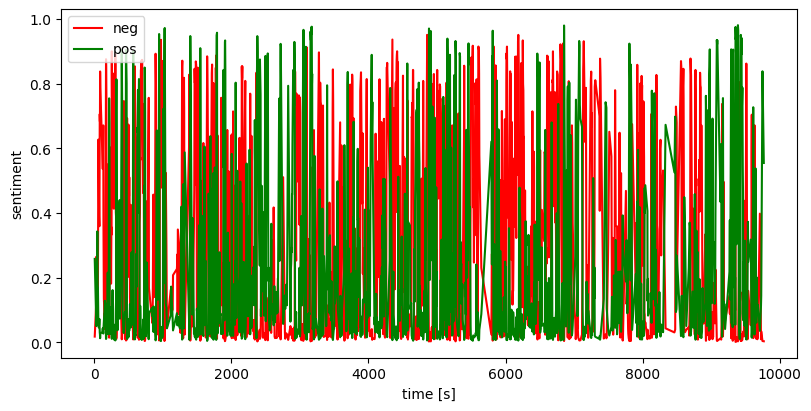

In [17]:
plt.figure(figsize=(8, 4), layout='constrained')
plt.plot(x, neg, color="red", label="neg")
plt.plot(x, pos, color="green", label="pos")
plt.xlabel("time [s]")
plt.ylabel("sentiment")
plt.legend()

In [18]:
diff = []
for i in range(len(x)):
    diff.append(pos[i] - neg[i])

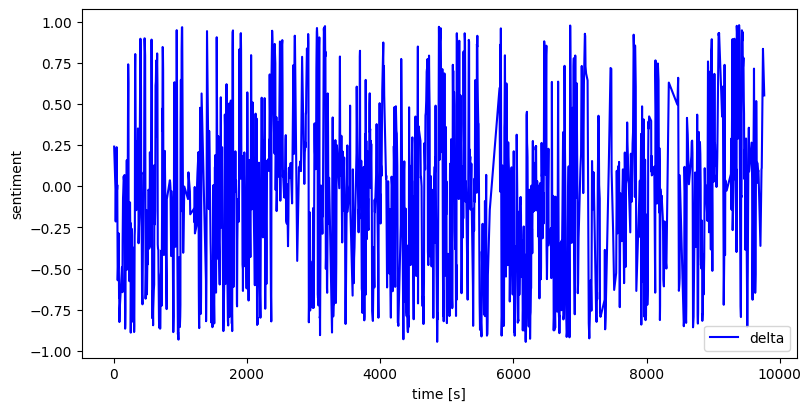

In [19]:
plt.figure(figsize=(8, 4), layout='constrained')
plt.plot(x, diff, color="blue", label="delta")
plt.xlabel("time [s]")
plt.ylabel("sentiment")
plt.legend()

In [20]:
def moving_average(x, width):
    return np.convolve(x, np.ones(width), 'valid') / width

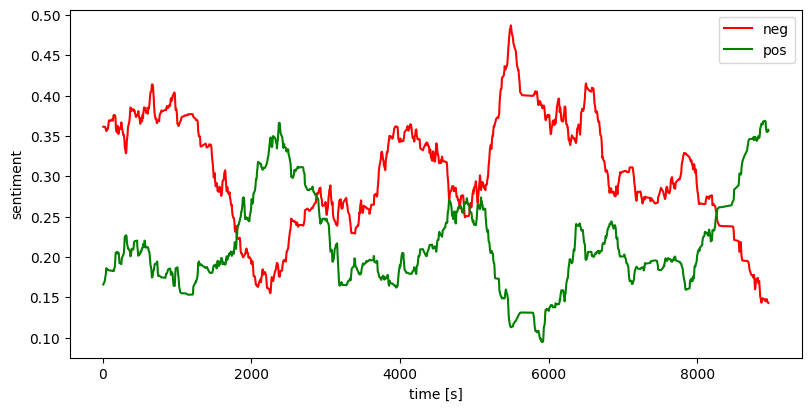

In [21]:
width = 128
avgNeg = moving_average(neg, width)
avgPos = moving_average(pos, width)
plt.figure(figsize=(8, 4), layout='constrained')
plt.plot(x[:len(avgNeg)], avgNeg, color="red", label="neg")
plt.plot(x[:len(avgPos)], avgPos, color="green", label="pos")
plt.xlabel("time [s]")
plt.ylabel("sentiment")
plt.legend()

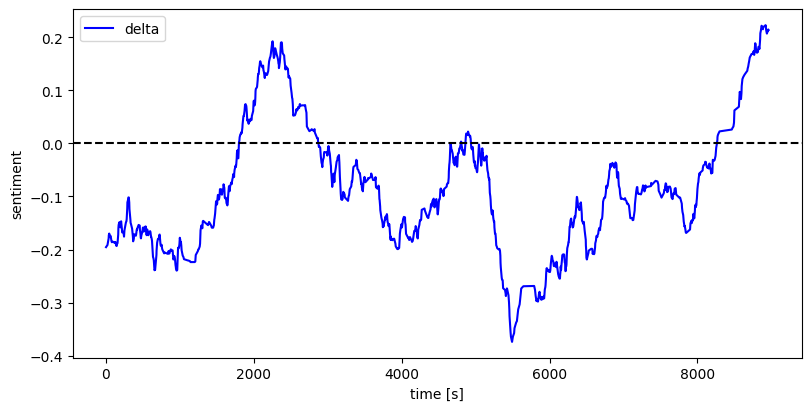

In [22]:
diff = []
for i in range(len(avgPos)):
    diff.append(avgPos[i] - avgNeg[i])
plt.figure(figsize=(8, 4), layout='constrained')
plt.plot(x[:len(avgPos)], diff, color="blue", label="delta")
plt.axhline(y=0, color="black", linestyle='--')
plt.xlabel("time [s]")
plt.ylabel("sentiment")
plt.legend()